Skipping .DS_Store: Unable to read image.
Processed image saved at mask/8.png


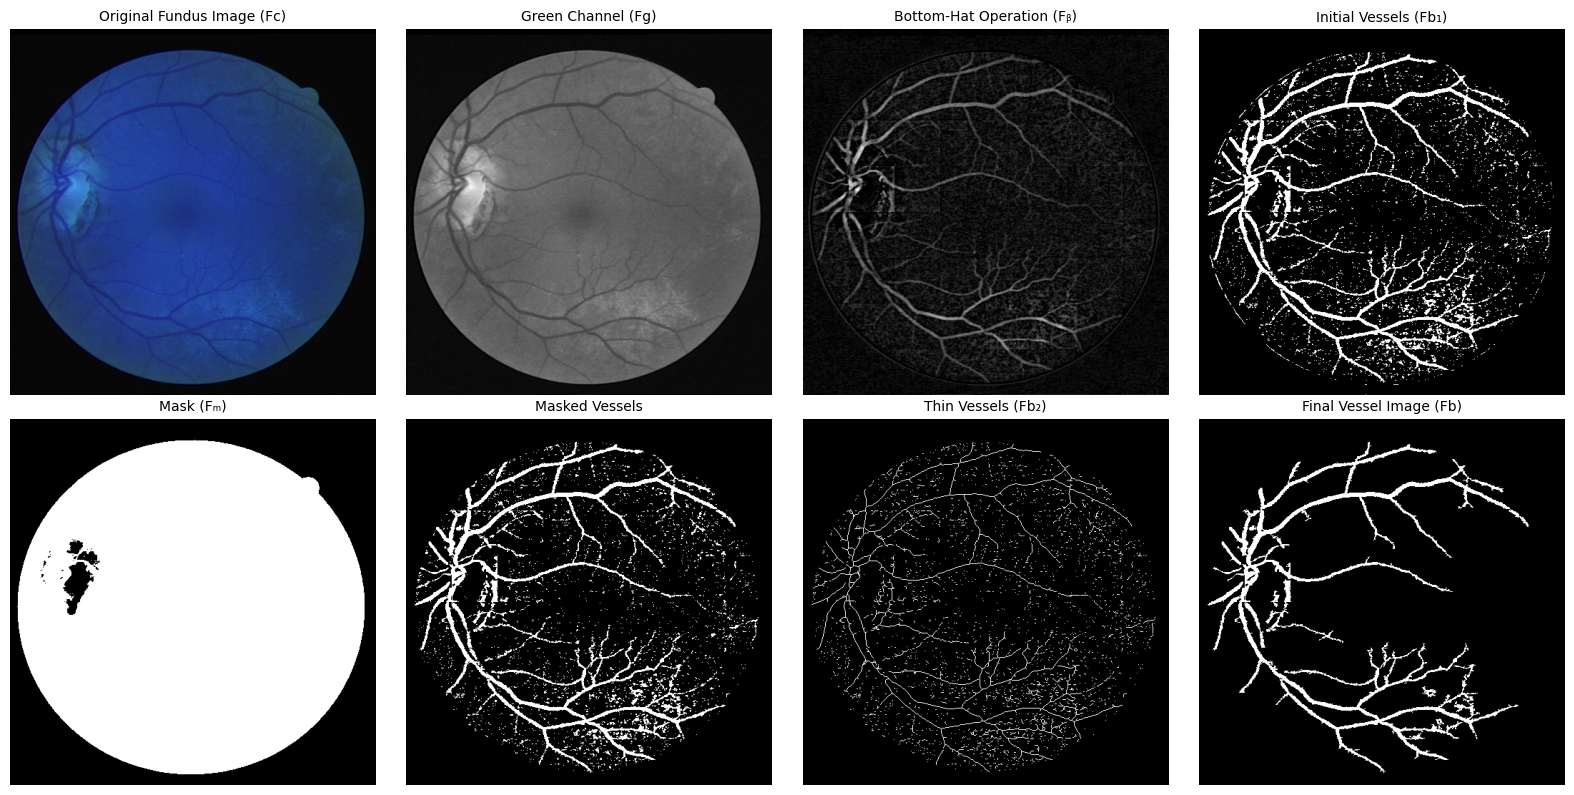

Processed image saved at mask/4.png


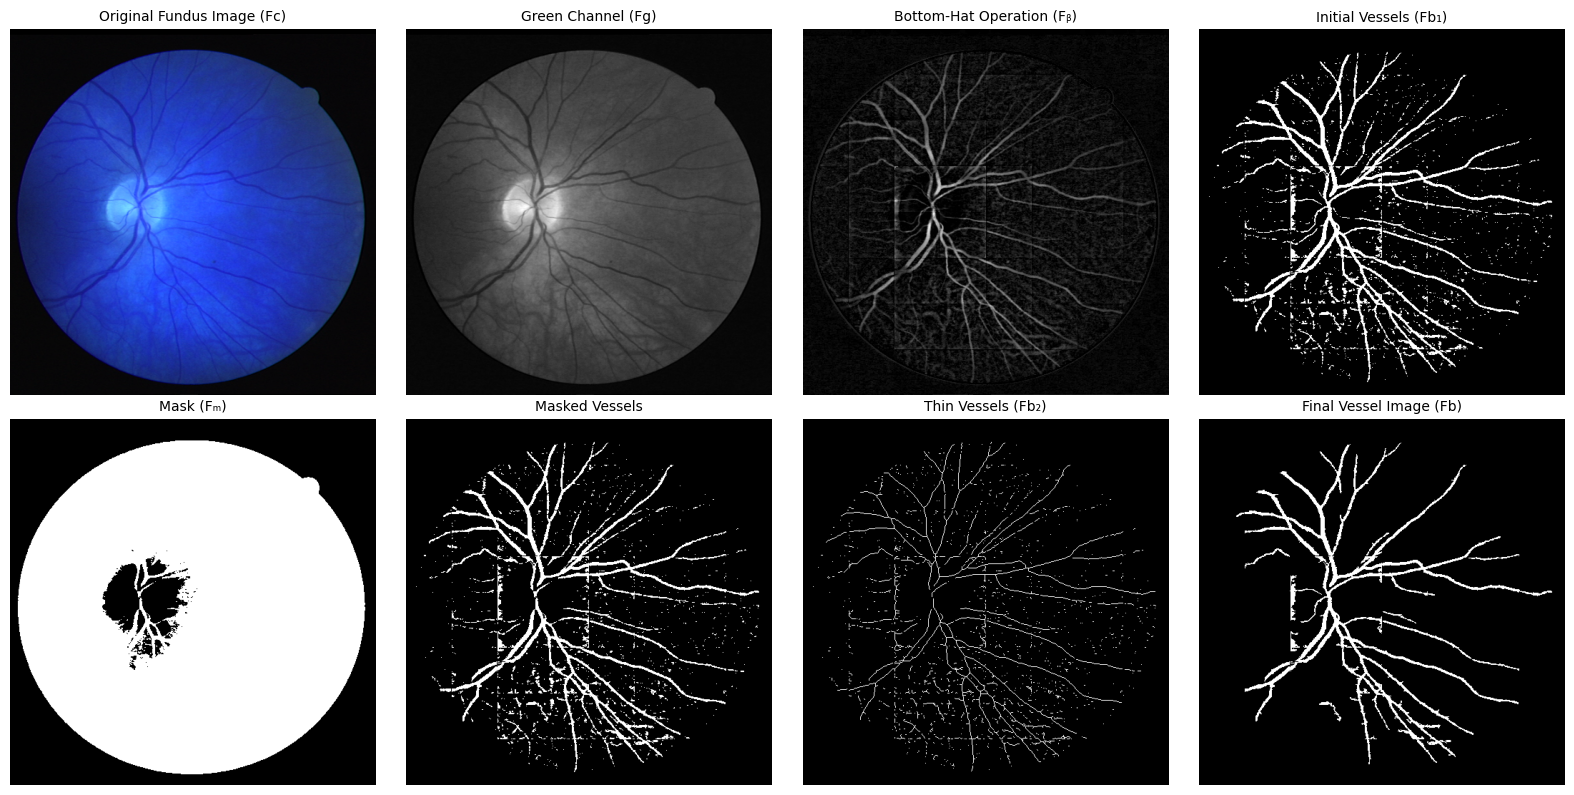

Processed image saved at mask/5.png


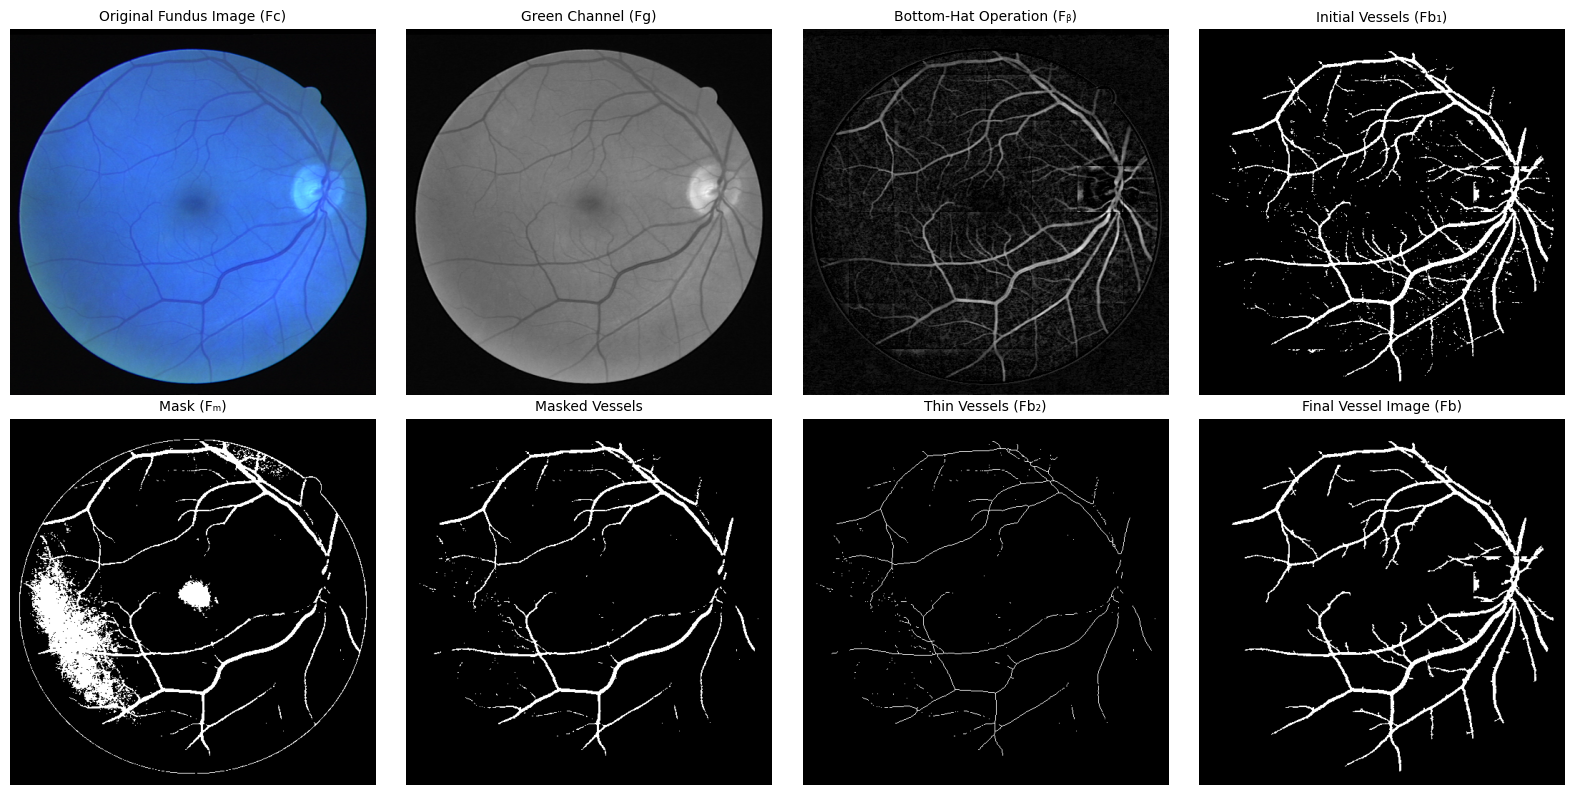

Processed image saved at mask/7.png


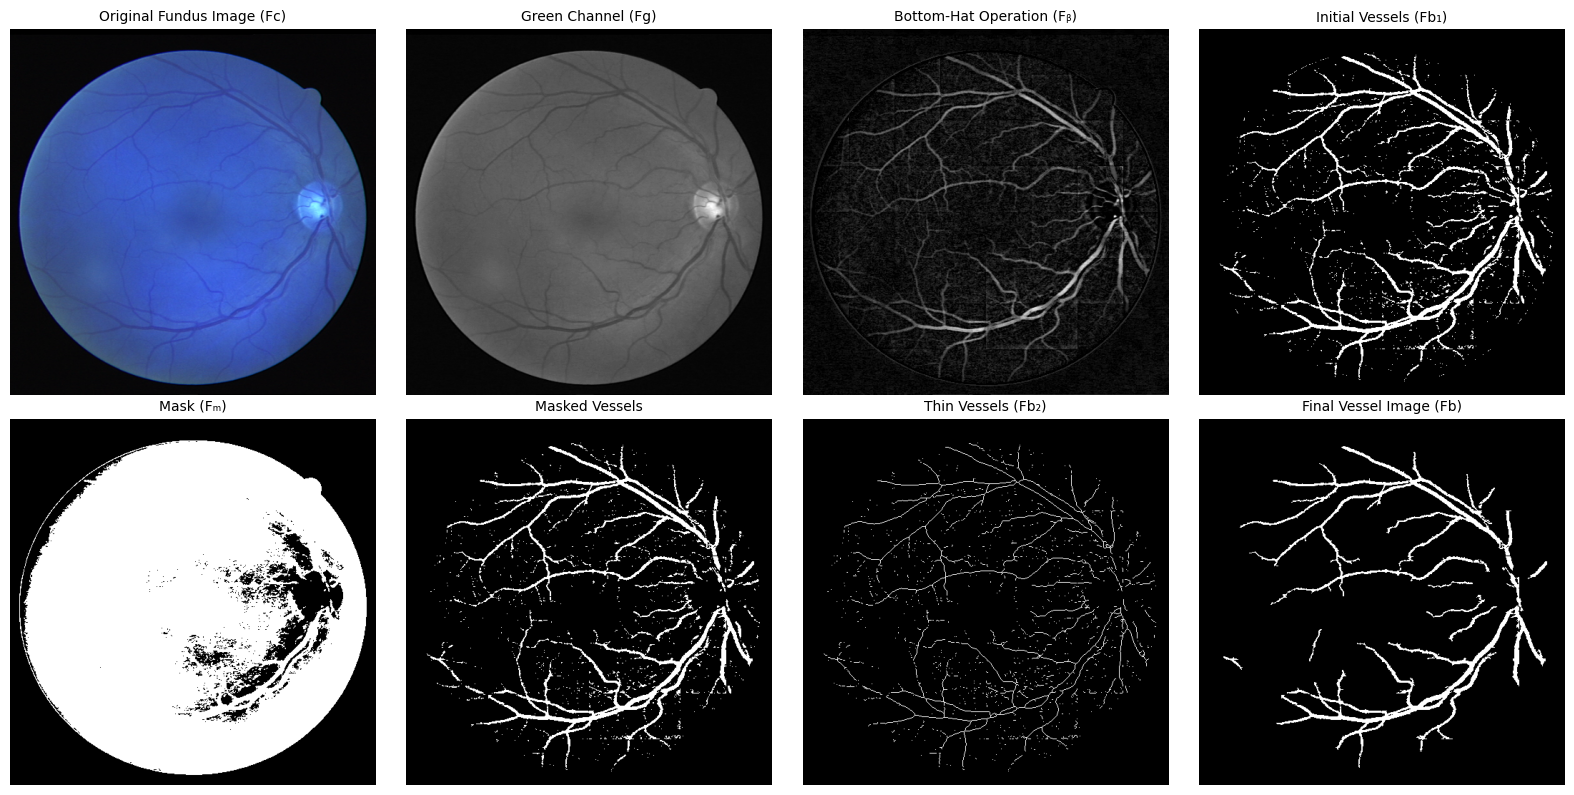

Processed image saved at mask/6.png


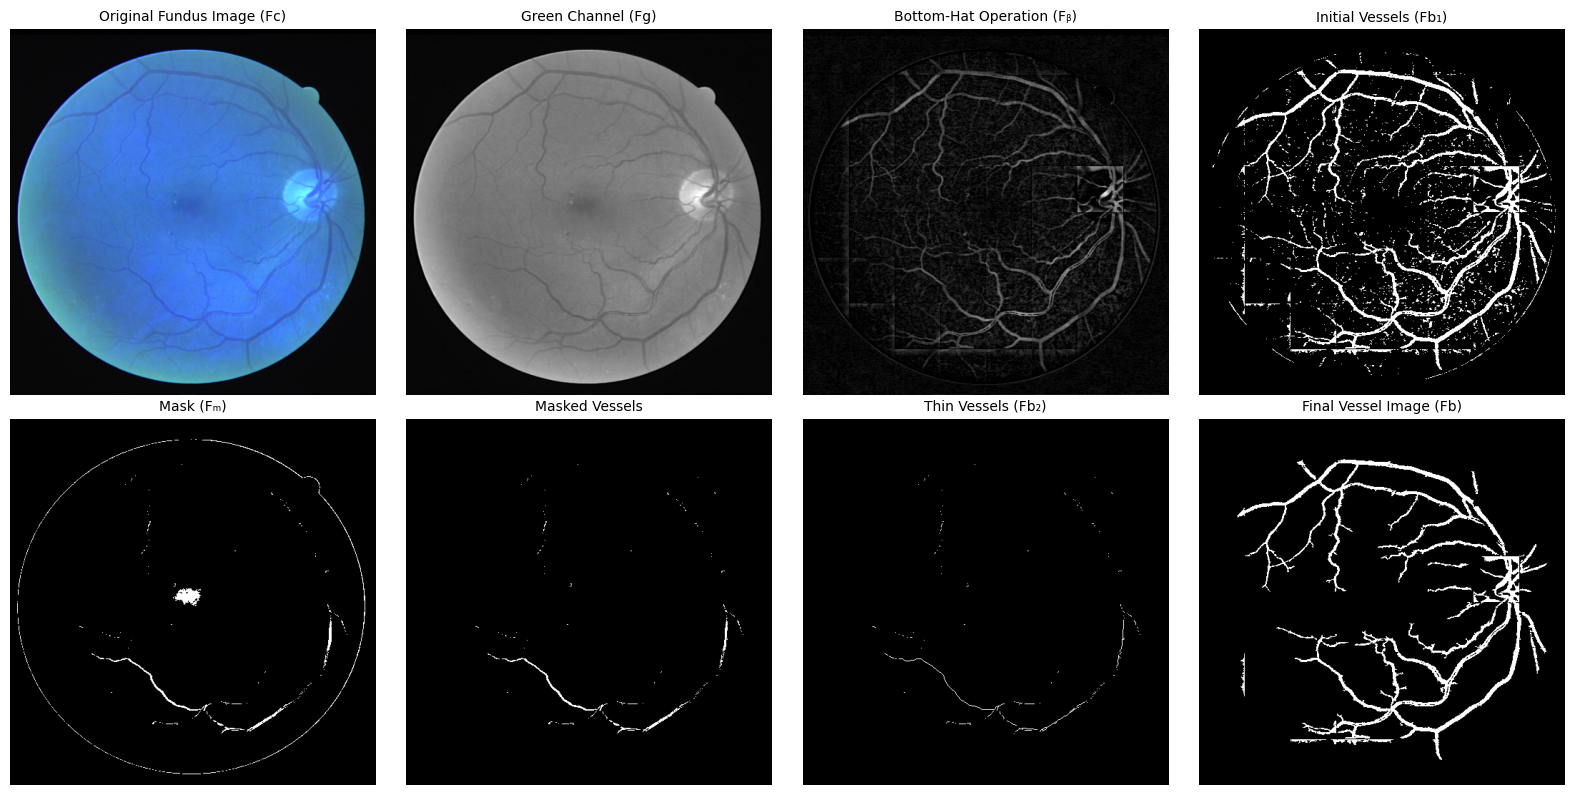

Processed image saved at mask/2.png


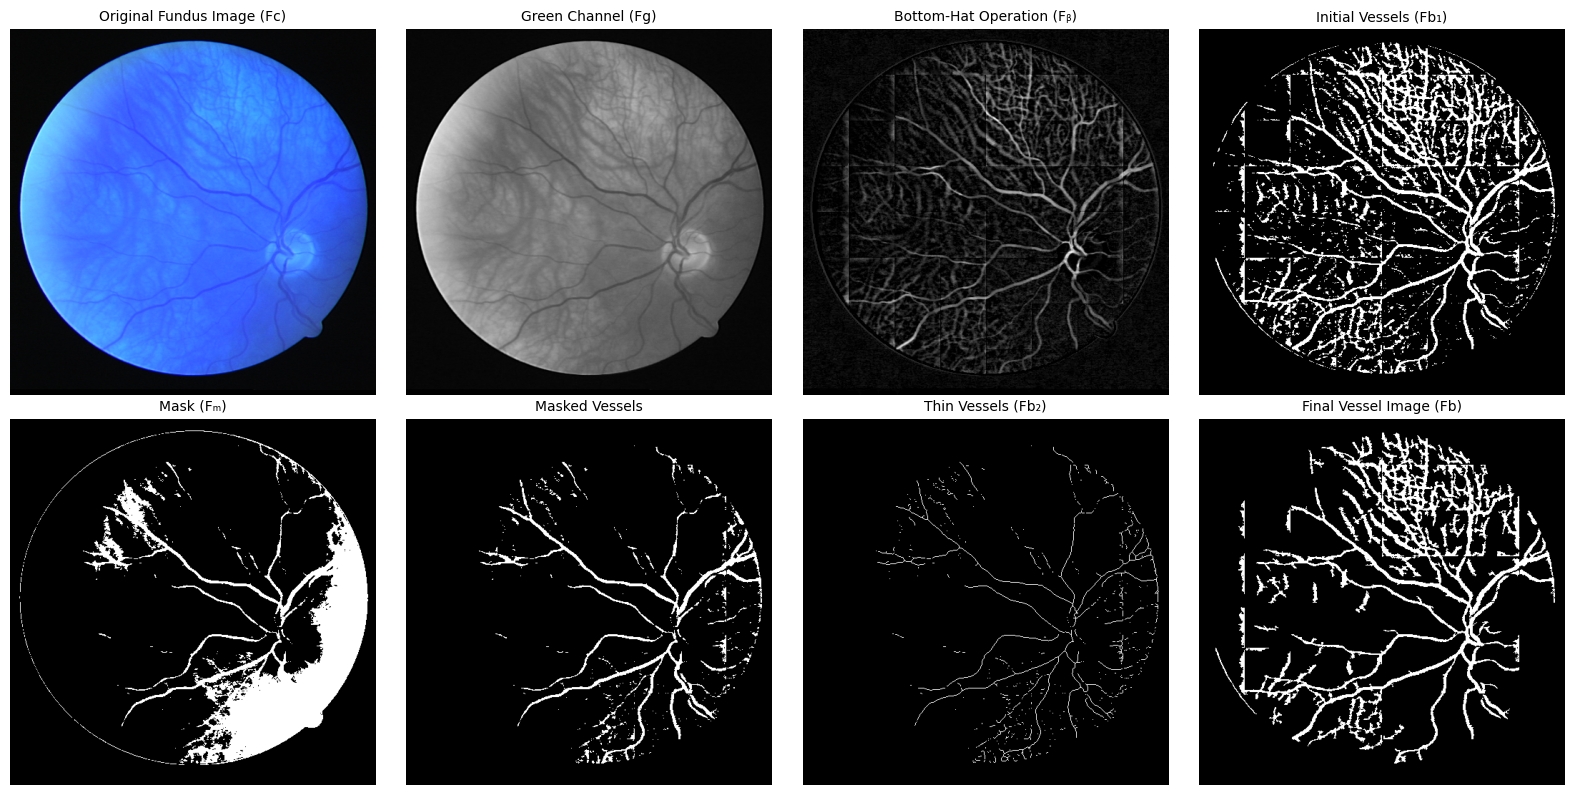

Processed image saved at mask/3.png


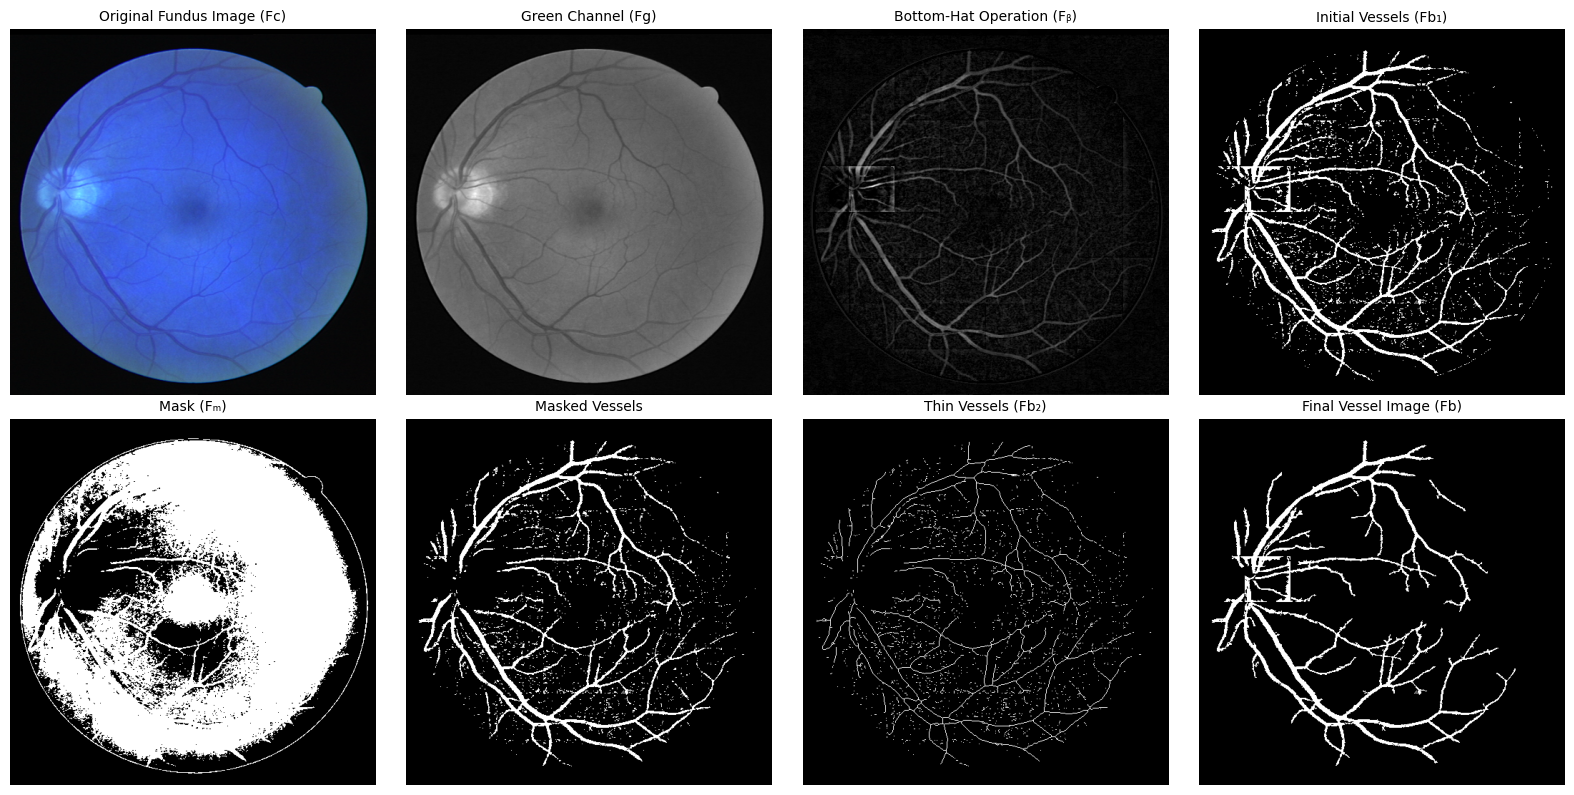

Processed image saved at mask/1.png


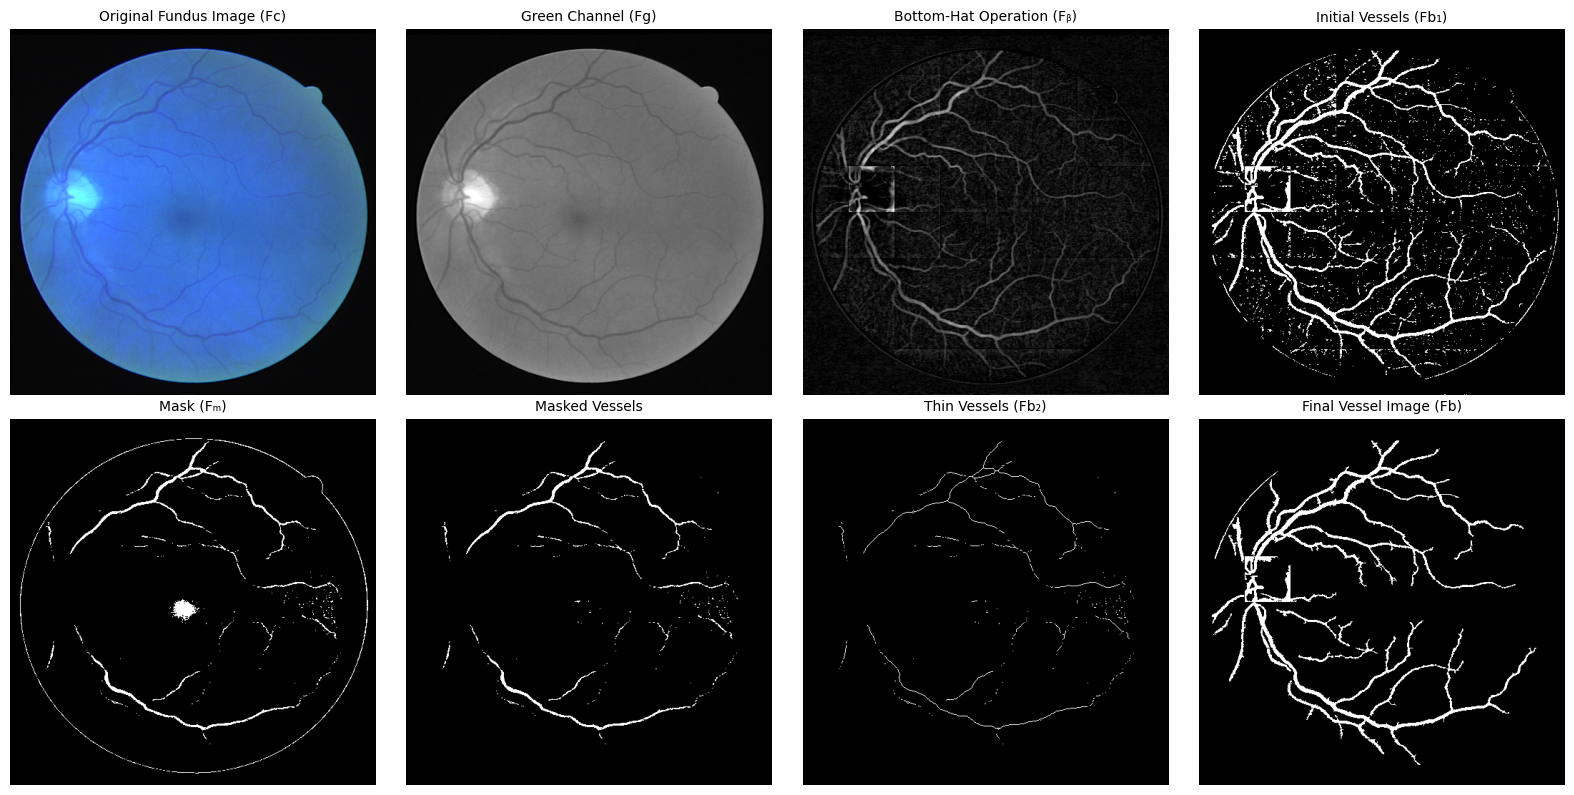

Processed image saved at mask/0.png


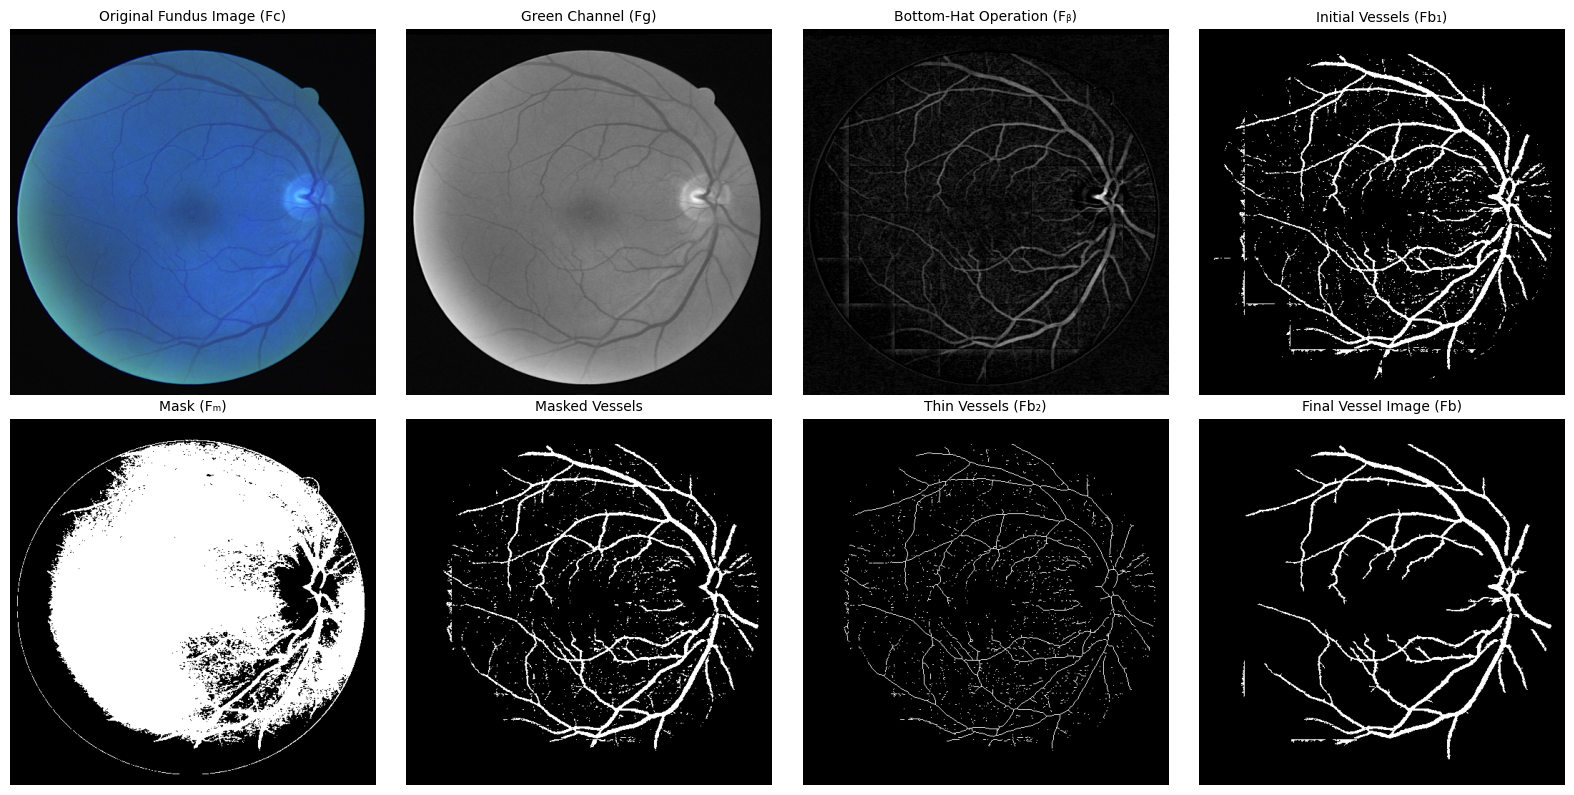

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.morphology import skeletonize, remove_small_objects

# Create mask folder if not exist
os.makedirs("mask", exist_ok=True)

# Prepare images for display
def prepare_image(image, cmap='gray'):
    if image.max() <= 1:  
        image = (image * 255).astype(np.uint8)
    return image, cmap

# Apply Clahe
def clip_histogram(hist, clip_limit):
    excess = np.sum(hist[hist > clip_limit] - clip_limit)
    hist = np.minimum(hist, clip_limit)
    hist += excess // len(hist)  
    return hist

def equalize_histogram(hist):
    cdf = np.cumsum(hist)
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf = np.uint8(np.clip(cdf, 0, 255))
    return cdf

def apply_clahe(image, clip_limit=3, tile_grid_size=(8, 8)):
    h, w = image.shape
    tile_h, tile_w = tile_grid_size
    step_h, step_w = h // tile_h, w // tile_w

    result = np.zeros_like(image, dtype=np.uint8)

    for i in range(tile_h):
        for j in range(tile_w):
            y1, y2 = i * step_h, (i + 1) * step_h
            x1, x2 = j * step_w, (j + 1) * step_w

            tile = image[y1:y2, x1:x2]
            hist, _ = np.histogram(tile.flatten(), bins=256, range=(0, 256))

            hist = clip_histogram(hist, clip_limit * step_h * step_w / 256)
            cdf = equalize_histogram(hist)

            result[y1:y2, x1:x2] = cdf[tile]

    return result


# Bottom Hat Filtering
def get_elliptical_kernel(size):
    k = np.zeros(size, dtype=np.uint8)
    center = (size[0] // 2, size[1] // 2)
    radius_x, radius_y = size[0] // 2, size[1] // 2

    for i in range(size[0]):
        for j in range(size[1]):
            if ((i - center[0])**2 / radius_x**2) + ((j - center[1])**2 / radius_y**2) <= 1:
                k[i, j] = 1

    return k

def dilate(image, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+k_h, j:j+k_w]
            output[i, j] = np.max(region[kernel == 1])

    return output

def erode(image, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+k_h, j:j+k_w]
            output[i, j] = np.min(region[kernel == 1])

    return output

def closing(image, kernel):
    dilated = dilate(image, kernel)
    closed = erode(dilated, kernel)
    return closed

def black_hat(image, kernel):
    closed_image = closing(image, kernel)
    return closed_image - image

# Morphology 
def get_elliptical_kernel(size):
    if size == (1, 1):  
        return np.ones((1, 1), dtype=np.uint8)

    k = np.zeros(size, dtype=np.uint8)
    center = (size[0] // 2, size[1] // 2)
    radius_x, radius_y = max(1, size[0] // 2), max(1, size[1] // 2)  

    for i in range(size[0]):
        for j in range(size[1]):
            if ((i - center[0])**2 / radius_x**2) + ((j - center[1])**2 / radius_y**2) <= 1:
                k[i, j] = 1

    return k


def erode(image, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+k_h, j:j+k_w]
            output[i, j] = np.min(region[kernel == 1])

    return output

def dilate(image, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+k_h, j:j+k_w]
            output[i, j] = np.max(region[kernel == 1])

    return output

def opening(image, kernel):
    eroded = erode(image, kernel)
    opened = dilate(eroded, kernel)
    return opened


def prepare_image(img, cmap):
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), None  
    return img, cmap

# Paths for input and output folders
input_folder = "image"
output_folder = "mask"
os.makedirs(output_folder, exist_ok=True)  

# Process all images in the input folder
for filename in os.listdir(input_folder):
    image_path = os.path.join(input_folder, filename)

    # Load the image
    fundus_image = cv2.imread(image_path)
    if fundus_image is None:
        print(f"Skipping {filename}: Unable to read image.")
        continue

    # Convert to RGB
    original_fundus = cv2.cvtColor(fundus_image, cv2.COLOR_BGR2RGB)

    # Extract the green channel
    green_channel = fundus_image[:, :, 1]

    # Apply Clahe
    enhanced_green = apply_clahe(green_channel)

    # Bottom-hat filtering
    kernel = get_elliptical_kernel((11, 11))
    bottom_hat = black_hat(enhanced_green, kernel)

    # Binarize to extract initial vessels
    _, initial_vessels = cv2.threshold(bottom_hat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Create a mask
    mask = cv2.inRange(green_channel, 20, 100)
    masked_vessels = cv2.bitwise_and(initial_vessels, initial_vessels, mask=mask)

    # Skeletonize to obtain thin vessels
    thin_vessels = skeletonize(masked_vessels > 0)

    # Combine initial vessels and thin vessels
    combined_vessels = cv2.bitwise_or(initial_vessels, thin_vessels.astype(np.uint8) * 255)

    # Apply Morphological Opening to remove small noise
    final_kernel = get_elliptical_kernel((1, 1))
    final_vessels = opening(combined_vessels, final_kernel)

    # Remove very tiny noise using Connected Component Analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(final_vessels, connectivity=8)

    # Define a minimum area threshold 
    min_area = 90
    denoised_vessels = np.zeros_like(final_vessels)

    # Keep only larger connected components
    for i in range(1, num_labels):  
        if stats[i, cv2.CC_STAT_AREA] > min_area:
            denoised_vessels[labels == i] = 255

    # Final cleaned vessel image
    final_vessels = denoised_vessels

    # Save the processed image in the output folder
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, final_vessels)
    print(f"Processed image saved at {output_path}")

    # Arrange all images for a single plot
    images = [
        (original_fundus, "Original Fundus Image (Fc)", None),
        (green_channel, "Green Channel (Fg)", 'gray'),
        (bottom_hat, "Bottom-Hat Operation (Fᵦ)", 'gray'),
        (initial_vessels, "Initial Vessels (Fb₁)", 'gray'),
        (mask, "Mask (Fₘ)", 'gray'),
        (masked_vessels, "Masked Vessels", 'gray'),
        (thin_vessels, "Thin Vessels (Fb₂)", 'gray'),
        (final_vessels, "Final Vessel Image (Fb)", 'gray'),
            ]

    # Plot all images in a single figure
    n_rows = 2
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))

    for i, (img, title, cmap) in enumerate(images):
        ax = axes[i // n_cols, i % n_cols]
        img, cmap = prepare_image(img, cmap)
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
 

In [66]:

import numpy as np
import matplotlib.pyplot as plt
import cv2

all_masks = []

# Read all predicted masks
for i in range(9):
        mask = cv2.imread('mask/' + str(i) + '.png')
        all_masks.append(mask)

# Encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(x.shape[0]*x.shape[1]):
        run_lengths.append([])
    current = 0
    count = 0
    start = 0
    flat = x.T.flatten()
    for i in range(len(flat)):
        dot = flat[i]
        if dot == 0:
            if current == 0:
                continue
            else:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
        else:
            if dot == current:
                count += 1
            elif count != 0:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
            else:
                start = i
                current = dot
                count += 1
    return run_lengths

# Write submission
import csv

# File name
filename = "submission.csv"

# Writing to CSV file
with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["id", "encoding"])  # Header
        for file_id in range(9):
            enc = rle_encoding(all_masks[file_id])
            writer.writerow([file_id, enc])  # Data row

print(f"{filename} has been created successfully.")


submission.csv has been created successfully.
